# COVID-19 Time Series Prediction Using Temporal Fusion Transformers 
## Bernhard Kaindl

**DISCLAIMER:** This project is part of Udacity's [Data Scientist Nanodegree](https://classroom.udacity.com/nanodegrees/nd025/dashboard/overview). The model shipped with this version of the project is to be understood as a _proof of concept_ or, at most, a starting point for further model improvements.

## Abstract - About the Project

In this project, we are going to train a [Temporal Fusion Transformer](https://arxiv.org/pdf/1912.09363.pdf) (TFT) for time series forecasting. We will use a dataset provided by _Our World in Data_ (OWID) and Jan Breitner's package [`pytorch-forecasting`](https://github.com/jdb78/pytorch-forecasting), which contains an easy-to-use implementastion of a TFT-model based on `torch`. 
The goal of this project is to provide an example of a pipeline for training and prediction, together with a minimal dashboard application using `dash` to provide an interactive interface to retrieve predictions made by the model on a per-country basis.  

## 1. On Temporal Fusion Transformers

Predictions of time series comprise a rather complex tier of prediction problems with a wide array of use cases in many fields. With advancements in machine learning, research has begun exploring the use of deep neural network algorithms for tackling time series predictions, yielding approaches involving both recurrent neural networks, as well as attention-based architectures, which havce proven useful for problems in image classification and natural language processing. 
TFTs as proposed by [Lim et al. (2020)](https://arxiv.org/pdf/1912.09363.pdf) employ attention mechanisms to enable probabilistic multi-horizon forecasting of time-series involving complex inputs, such as past covariates and known - or assumed - future inputs. Furthermore, while providing high-performance forecasts, TFTs also allow for interpretation of the results, as will be demonstrated on the trained model.

## 2. Problem Domain and Method

This project is intended to be a proof of concept to demonstrate the usefulness of TFTs in time series forecasting in areas outside of purely business-focused settings. To this end, this project will examine pandemic data on COVID-19. As such, model performance in forecasting accuracy is secondary, also since training TFTs on large datasets is resource intense. 
The training run for the final model chosen in this project needed about 4.5 hours to finish (only for fitting) with eight 2.8 GHz CPU cores and 8 GB GPU RAM.
Nonetheless, this project should provide the interested practitioner with a starting point either to improve upon this model or to use `pytorch-forecasting` and TFTs for their own use case.
The following will be covered in this notebook:
- Data Retrieval & Preprocessing
- Configuring WANDB for Monitoring and Tuning of the Model 
- Interpretation/Discussion of Attention and Variable Importance

For the prediction pipeline, you can have a look at the Dash application coming in the same repository.

## 3. Data

There are several methods for retrieving the data. The most straightforward one is to download the data directly from 'https://covid.ourworldindata.org/data/owid-covid-data.json'. However, as the data there is updated on a daily basis, we need some way to keep track of which dataset we are using in order to make models comparable. 
One could download and save the data using a timestamp, for example. I peronally used [WANDB's artifact system](https://docs.wandb.ai/artifacts), which versionsdatasets and allows a good deal of control over which model is trained on which data.

For this example, however, I have already prepared the dataset I used to train the final model. I will leave a snippet commented out to demonstrate how to generate a dataset artifact using `wandb`.

In [1]:
import torch
import json
import numpy as np
import pandas as pd
import requests

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, DeepAR
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from data_retrieval import retrieve_data_from_url, prepare_data
from datetime import date as dt

import wandb

In [2]:
# initialize offline run to load configuration file
# for online syncing change mode to online and adjust project parameter and run name
run = wandb.init(project="capstone", 
                 name="submission", 
                 mode="offline", 
                 job_type="data_retrieval", 
                 reinit=True, 
                 config='run_config.yml')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.


In [3]:
# # optional: download data and create new artifact

# URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'
# df = retrieve_data_from_url(URL)

# # the data in the raw json contains a column with the time-series data in a nested structure
# # run prepare_data on raw output to get one row with all the data per country & per day

# data, x_df, info = prepare_data(df)

# # record timestamp to add retrieval date to artifact metadata
# timestamp = dt.strftime(dt.today(), "%Y%m%d")

# # register artifact with URL to move version number and to log usage
# data_artifact = wandb.Artifact("covid-data", type="dataset", metadata={"retrieval" : timestamp})
# # data_artifact.add_file('cleaned')
# data_artifact.add_reference(URL, name="covid_json", checksum=True)
# run.log_artifact(data_artifact)

For the final model, I used [`covid-data:v4`](https://wandb.ai/kaiharuto/capstone/artifacts/dataset/covid-data/961a07a07d5586309848) as training data. As the data artifacts in WANDB only contain the URL as reference, we need to do the same preparation in `prepare_data` as in the cell above. 

In [4]:
#load raw data from file and prepare
df = pd.read_json("data/covid-data:v4/covid_json", orient="index")
data, x_df, info = prepare_data(df)

In [5]:
data.head()

,location,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty,female_smokers,male_smokers,time_idx,month
0,AFG,2020-02-24,1.0,1.0,0.026,0.026,8.33,NaN,NaN,NaN,...,9.59,37.746,0.5,64.83,0.511,NaN,NaN,NaN,54,2
1,AFG,2020-02-25,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.5,64.83,0.511,NaN,NaN,NaN,55,2
2,AFG,2020-02-26,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.5,64.83,0.511,NaN,NaN,NaN,56,2
3,AFG,2020-02-27,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.5,64.83,0.511,NaN,NaN,NaN,57,2
4,AFG,2020-02-28,1.0,0.0,0.026,0.000,8.33,NaN,NaN,NaN,...,9.59,37.746,0.5,64.83,0.511,NaN,NaN,NaN,58,2


In [6]:
data.date.min(), data.date.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-02-19 00:00:00'))

In [7]:
import matplotlib.pyplot as plt

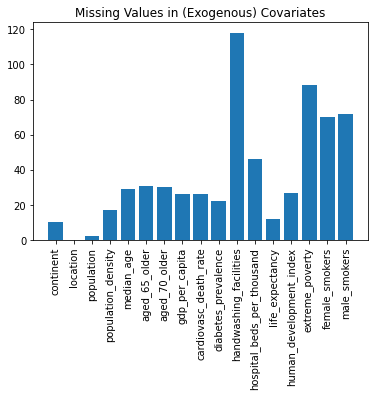

In [8]:
# plot nans in xs
x_nans_sums = info["x_nan_sums"]

x_ax_labels = [k for k,v in x_nans_sums.items()]
x_ax_values = [v for k,v in x_nans_sums.items()]

plt.bar(x_ax_labels,x_ax_values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

The graph above shows already the first challenge we are facing with this dataset. For quite a few exogenous variables, we have a problem with missing values. In fact, when experimenting to find a good configuration for model training, trying out different approachs for dealing with NaNs was quite important.
As we will see, however, for the final model, replkacing the NaNs with zeroes yielded acceptable results, but keeping this in mind for further improvements on the model might help.

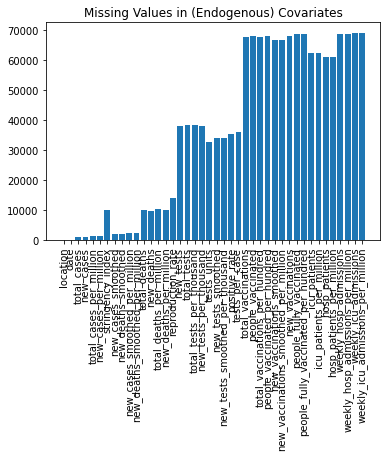

In [9]:
y_nans_sums = info["y_nan_sums"]

y_ax_labels = [k for k,v in y_nans_sums.items()]
y_ax_values = [v for k,v in y_nans_sums.items()]

plt.bar(y_ax_labels,y_ax_values)
plt.title("Missing Values in (Endogenous) Covariates")
plt.xticks(rotation = 90);

This chart shows that we might have a similar problem for many of our potential target v. Luckily, for our case, where we use `new_cases_smoothed` as our target, we might not lose too many observations.

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


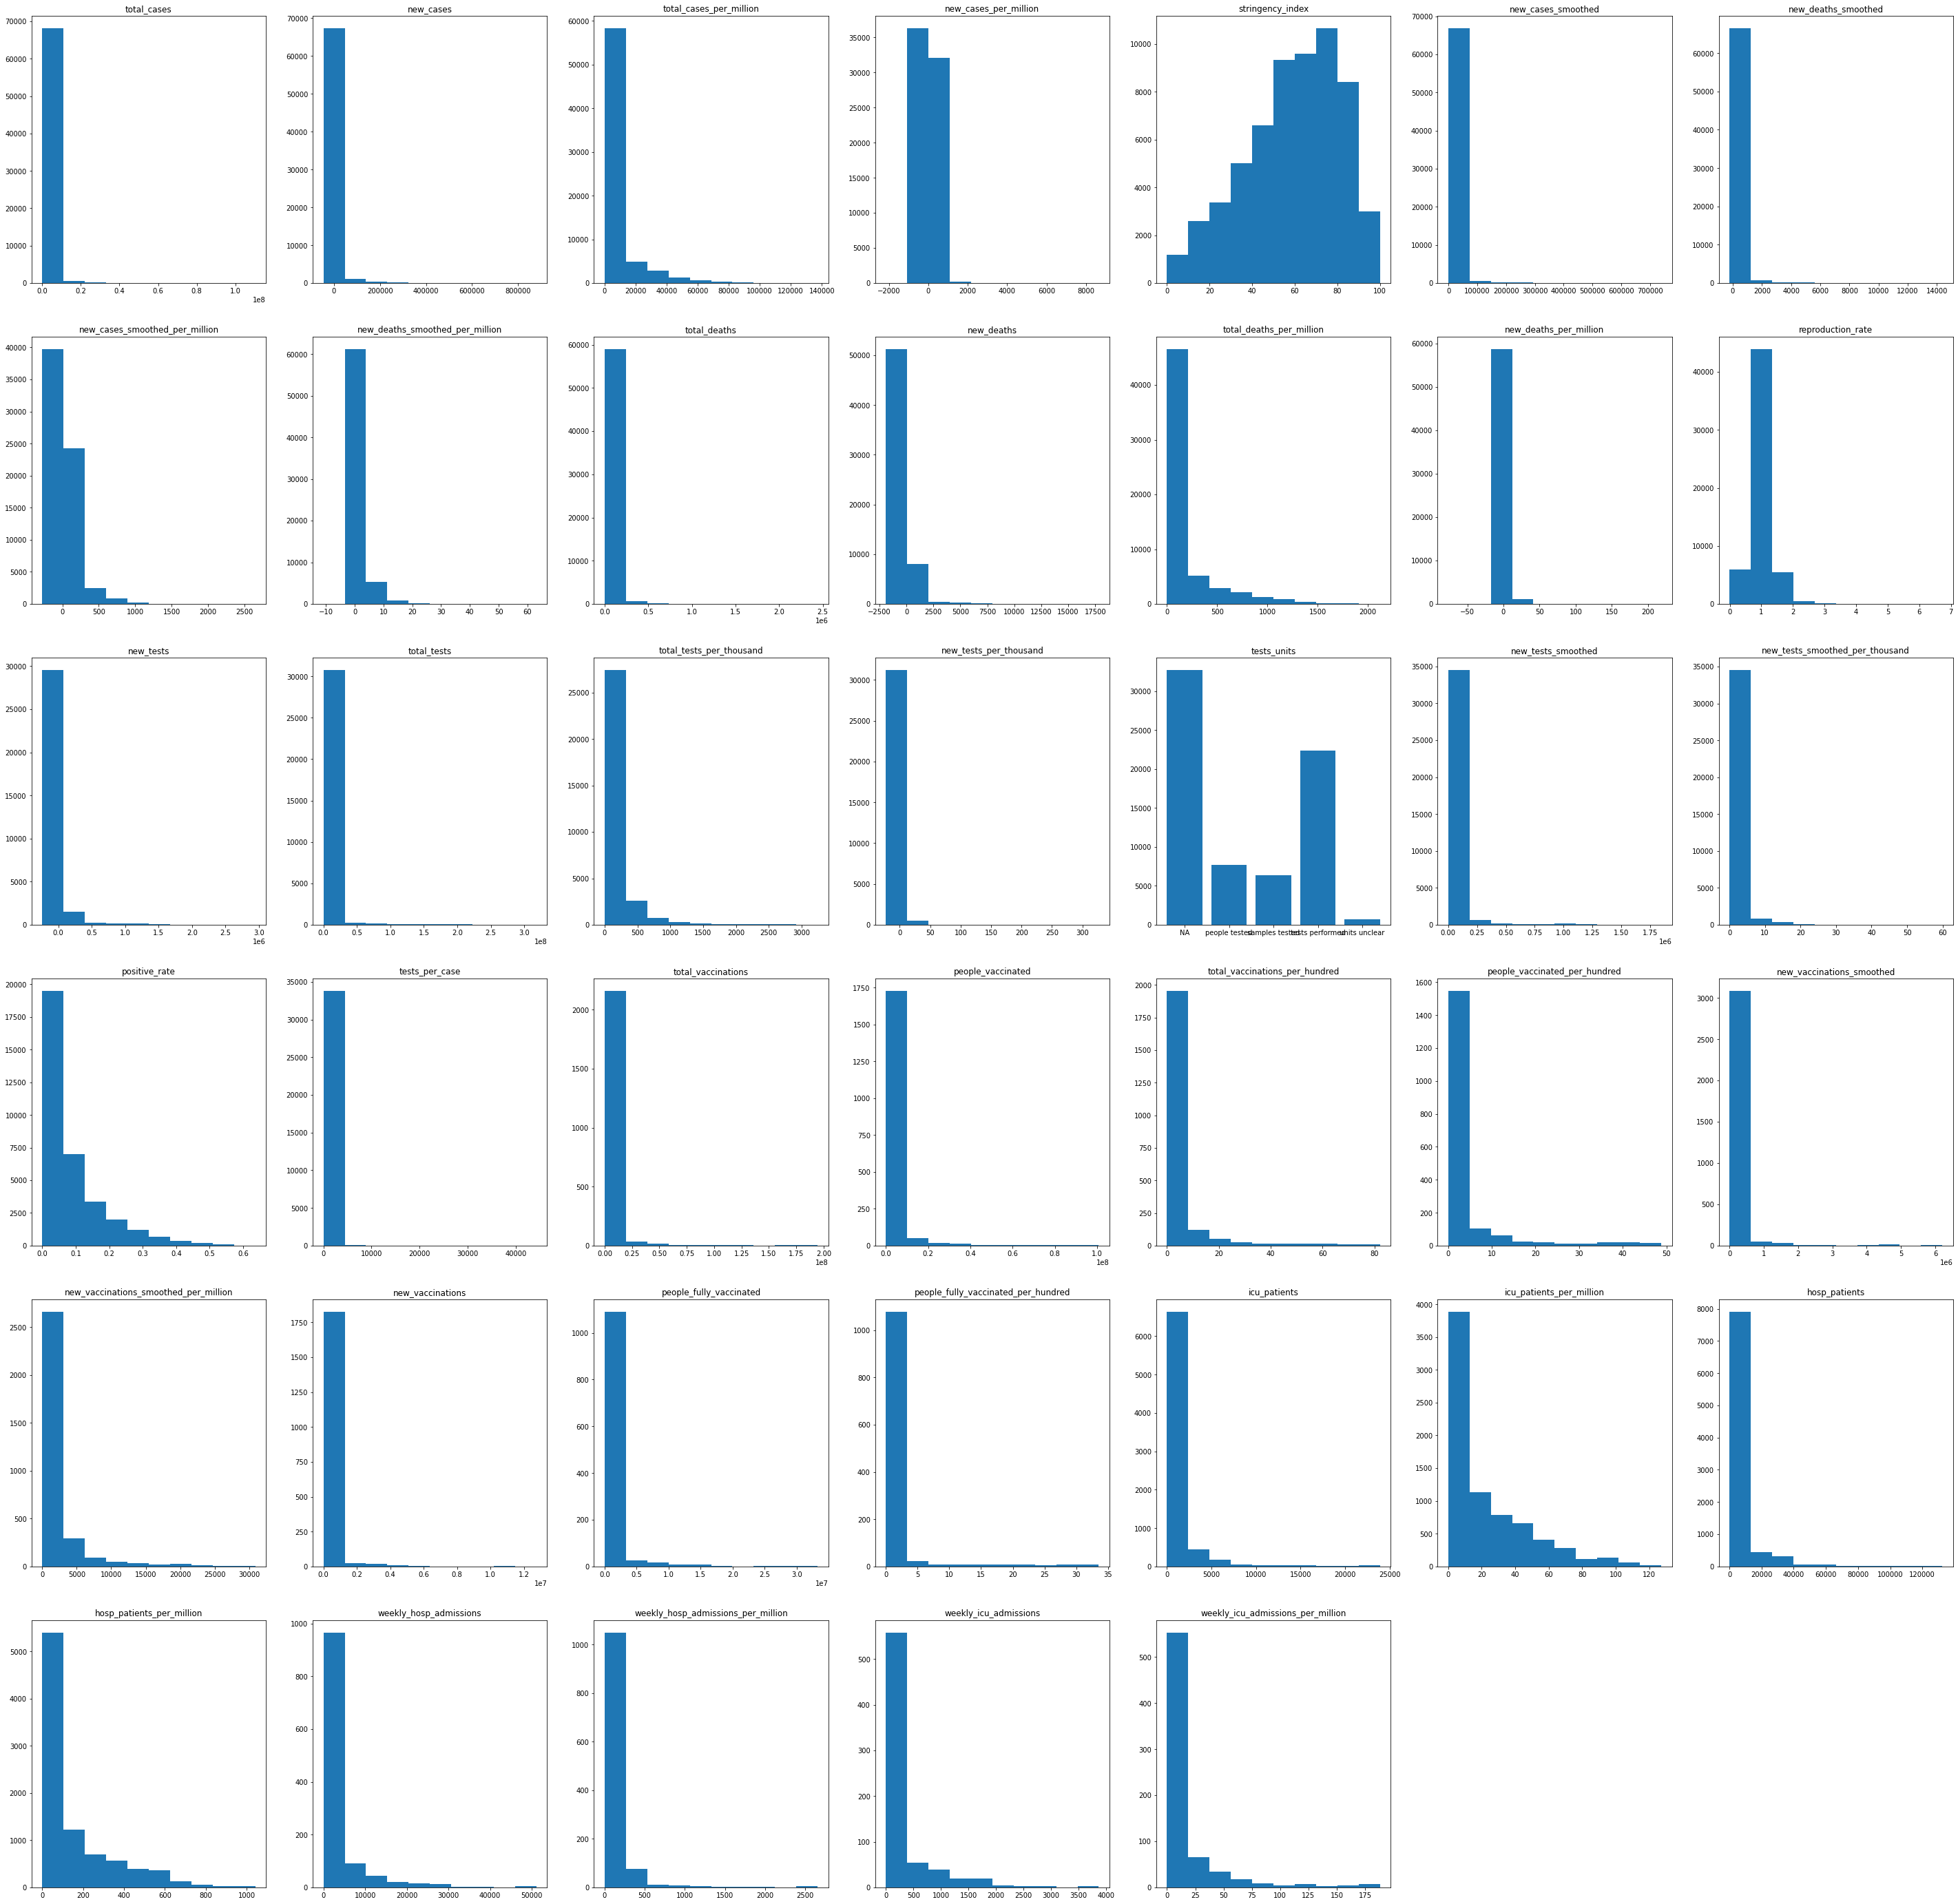

In [10]:
# plot histograms for all (potential) ys
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(50,50))
# ax.set_title("Distribution of Covariates")

i = 0
ys = info["y_nan_sums"].keys()
for x in ys:
    if(x in ['location', 'date']):
        continue
    
    else:
        
        i += 1
        ax = fig.add_subplot(6,7,i)

        if is_numeric_dtype(data[x]):

            ax.set_title(x)
            ax.hist(data[x],density=False)

        else:

            ax.bar(data.groupby(x).size().index, data.groupby(x).size())
            ax.set_title(x)
        
        
fig;

When looking at the distributions of the endogenous variables, we can quickly tell that most of them are left-skewed, except for the `stringency_index` describing the strictness of regulatory measures, which is slightly skewed to the right. This makes sense, as very few governments have not imposed any kind of restriction during the pasndemic.

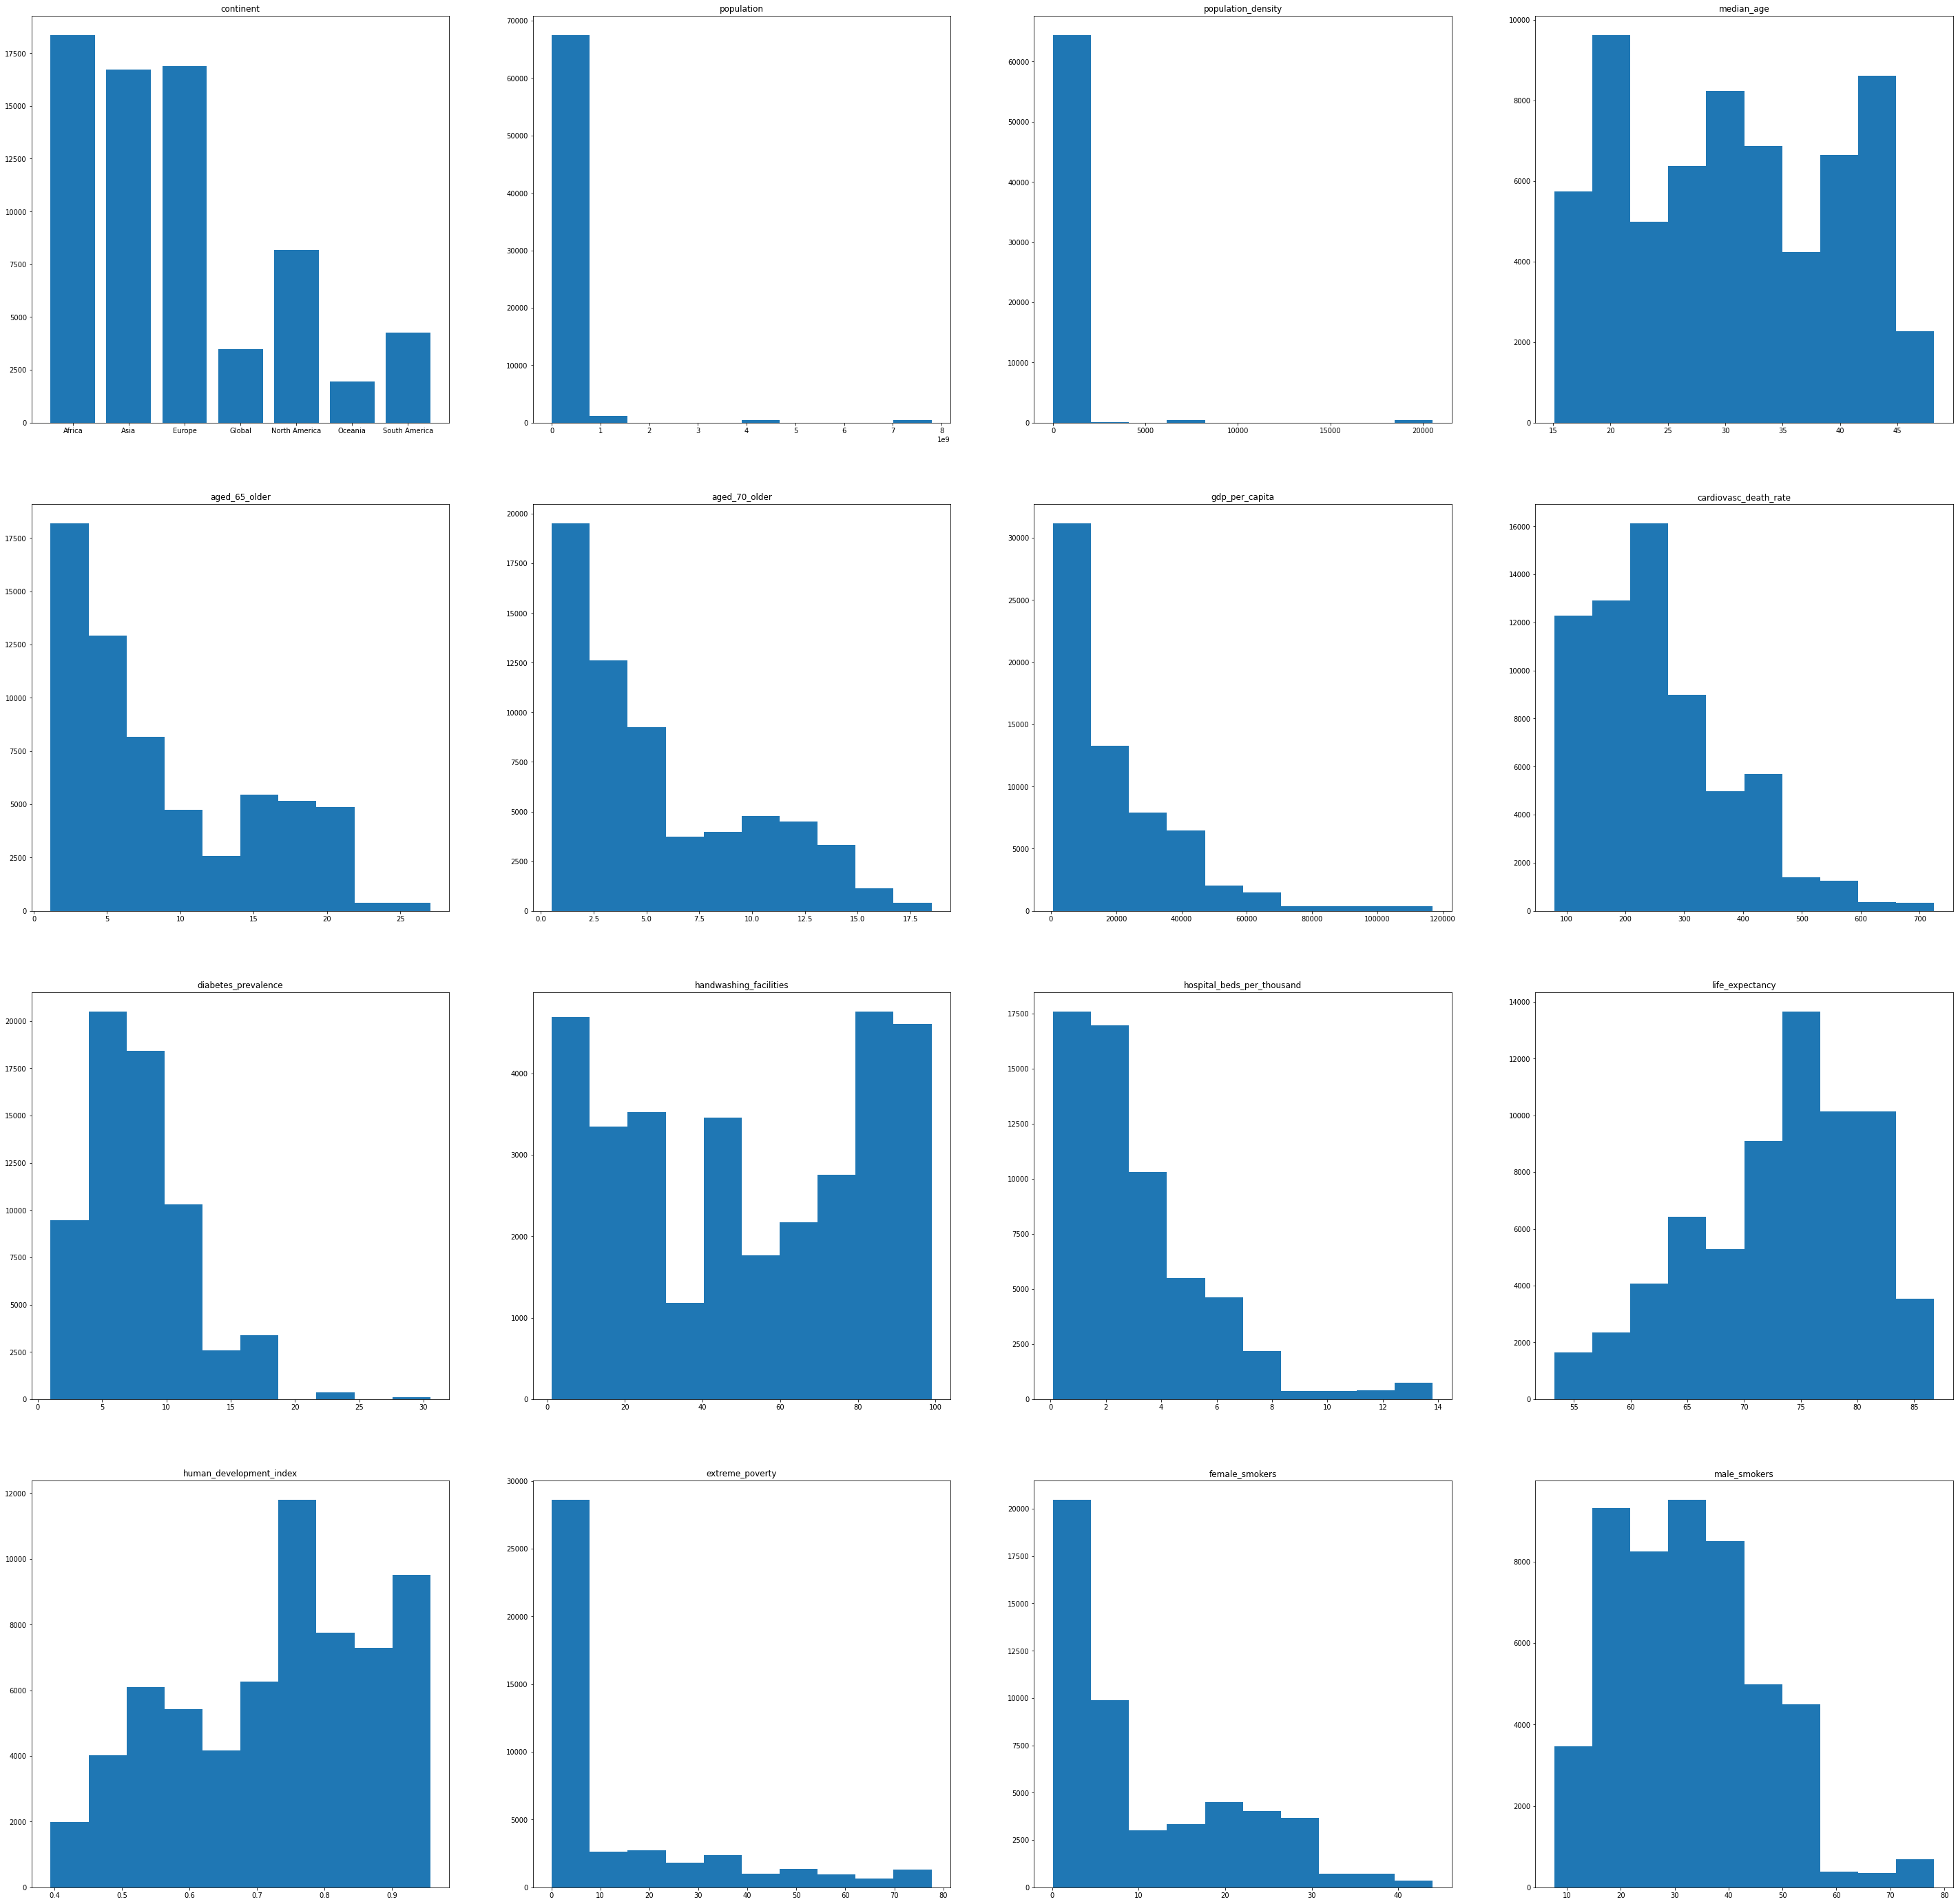

In [11]:
# plot histograms for all (potential) xs
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(50,50))
# ax.set_title("Distribution of Covariates")

i = 0
xs = info["x_nan_sums"].keys()
for x in xs:
    if(x in ['location', 'date']):
        continue
    else:
        
        i += 1
        ax = fig.add_subplot(4,4,i)

        if is_numeric_dtype(data[x]):

            ax.set_title(x)
            ax.hist(data[x],density=False)

        else:

            ax.bar(data.groupby(x).size().index, data.groupby(x).size())
            ax.set_title(x)
        
        
fig;

Looking at the distrributions for the exogenous and time-invariant variable is not very informative. The most interesting observation here is the diastribution of `handwashing_facilities`, where there seems to be quite some variance among the few countries where we actually do have values for this variable.
Idiosyncratic (i.e. within-country) errors can luckily be neglected, as `pytorch forecasting` applies a [by-group normalization](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.encoders.GroupNormalizer.html?highlight=group#groupnormalizer), alleviating effects that we would see from strong variance within one country over time.

Now, we can have a look at our model setup. Since we use `wandb`, most parameters can be configured in `run_config.yml` (with one exception). It is still instructive to have a look at the parameters. The YAML file provides a short definition for each of them.

## 4. Configuring the Training Run

In [12]:
print("Final Parameters used")
for param, value in run.config.items():
    print(param + ": " + str(value))

Final Parameters used
max_pred_length: 7
max_encoder_length: 180
max_epochs: 50
gradient_clip_val: 0.03
learning_rate: 0.03
hidden_size: 16
attention_head_size: 4
dropout: 0.25
hidden_continuous_size: 4
reduce_on_plateau_patience: 8
output_size: 7
transformation: softplus
impute_strategy: median
n_neighbors: 8
weights: distance
targets: new_cases_smoothed
static_reals: ['population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers', 'male_smokers']
time_varying_known_reals: ['time_idx', 'stringency_index', 'new_tests_smoothed', 'new_vaccinations_smoothed', 'new_deaths_smoothed']


Note that `max_pred_length`  aned `max_encoder_length` are both given in days. Also, `time_varying_known_reals` might not actually be known for the forecast period, but can be assumed and set during prediction for "counterfactual" forecasts.
Another point to note is that `impute_strategy`, `n_neighbors`, and `weights`, are only used if imputers from sklearn are used to replace missing values. Below is the code for setting these values without a yaml file and for setting up WANDB for logging during training.

Also note that `training_cutoff` cannot be specified in the YAML as it is a computed parameter!

The parameters and their comments are gratefully taken from [this tutorial on `pytorch-forecasting`](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html#Create-dataset-and-dataloaders)

In [13]:
# set up wandb-based logging for prototype

wandb_logger = WandbLogger(name='submission' + "_training",project="capstone")

# set model parameters for wandb
config = wandb.config

# model configs for wandb

# config.max_pred_length = 7 # predict at most two weeks
# config.max_encoder_length = 180  # use at most ~6 months as input
config.training_cutoff = data['time_idx'].max() - config.max_pred_length
# config.max_epochs = 50
# config.gradient_clip_val = 0.03
# config.learning_rate = .08
# config.hidden_size = 16
# # number of attention heads. Set to up to 4 for large datasets
# config.attention_head_size = 4
# config.dropout = 0.25  # between 0.1 and 0.3 are good values
# config.hidden_continuous_size = 4  # set to <= hidden_size
# config.output_size = 7  # 7 quantiles by default
# # reduce learning rate if no improvement in validation loss after x epochs
# config.reduce_on_plateau_patience = 4
# config.targets = 'new_cases_smoothed'
# config.static_reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
#                     'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
#                     'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers']
# config.time_varying_known_reals = ['time_idx','stringency_index', 'new_tests_smoothed',"new_vaccinations_smoothed", 
#                                    "new_deaths_smoothed"
#                                    ] # in reality unknown but could be used for conditional forecasts
# config.transformation = "softplus"
# config.impute_strategy = "median"
# config.n_neighbors = 8
# config.weights = "distance"

Now comes the point where we need to care about the missing values, as we need to construct our training dataset. I decided to simply fill them with 0, which during experimentation worked out better than using more sophisticated imputation strategies.
In the model, this led to predictions being excessively high if a country had very low case numbers over the last 180 days, as this could be interpreted as the respective country underreporting numbers.
To offset this effect slightly, I added dummy variables for missing observations.

In [14]:
# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation following https://www.kaggle.com/dansbecker/handling-missing-values

train_data = data.copy()

# drop "FSM" (Micronesia) Columns that only appeared as of 2021/01/21
# this removal needs to be maintained as the loaded model in this example was trained
# without these entries.
train_data.drop(index=data.loc[data.location == "FSM"].index, inplace=True)

# make new columns indicating what will be imputed
cols_with_missing = (col for col in [*config.static_reals, *config.time_varying_known_reals,
                                     config.targets]
                                 if train_data[col].isnull().any())
for col in cols_with_missing:
    train_data[col + '_was_missing'] = train_data[col].isnull()


train_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]] = train_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]].fillna(0) 


impute_dummies = [col for 
                  col in train_data.columns if col.endswith("_was_missing")]

train_data[impute_dummies] = train_data[impute_dummies].astype("str").astype("category")

# if the dataset still contains missing values for the target, count them and drop them 
missing_targets = train_data.loc[train_data[config.targets].isna()][["location","date"]].copy(deep=True)
train_data.drop(index=missing_targets.index, inplace=True)



training = TimeSeriesDataSet(
    train_data[lambda x: x.time_idx <= config.training_cutoff],
    time_idx='time_idx',
    target=config.targets,
    group_ids=['location'],
    min_encoder_length=int(config.max_encoder_length // 2),
    max_encoder_length=config.max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=config.max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'], 
    static_reals = config.static_reals,
    time_varying_known_categoricals=['month', *impute_dummies], #allow for missings to be flagged on country-level over time - needs to be assumed in forecasts
    time_varying_known_reals=config.time_varying_known_reals,
    target_normalizer=GroupNormalizer(groups=['location'], transformation=config.transformation),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, train_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)
print("Dropping the following for missing target values: \n\n ", missing_targets)

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'AIA'}, {'__group_id__location': 'BMU'}, {'__group_id__location': 'CYM'}, {'__group_id__location': 'FRO'}, {'__group_id__location': 'GGY'}, {'__group_id__location': 'GIB'}, {'__group_id__location': 'GRL'}, {'__group_id__location': 'IMN'}, {'__group_id__location': 'JEY'}, {'__group_id__location': 'MAC'}]
  warnings.warn(


Dropping the following for missing target values: 

  Empty DataFrame
Columns: [location, date]
Index: []


/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'AIA'}, {'__group_id__location': 'BMU'}, {'__group_id__location': 'CYM'}, {'__group_id__location': 'FRO'}, {'__group_id__location': 'GGY'}, {'__group_id__location': 'GIB'}, {'__group_id__location': 'GRL'}, {'__group_id__location': 'IMN'}, {'__group_id__location': 'JEY'}, {'__group_id__location': 'MAC'}]
  warnings.warn(


As the warnins tell us, we have quite a few countries that do not have enough data for us to make predictions. We will account for those during prediction on new data, which will be briefly discussed in this notebook to give an overview. of how the prediction pipeline works in Dash. 

`pytorch-forecasting` provides a method to compute a simple baseline based on the mean average error (MAE) of a model that simply forward fills the target. As easy to beat as this might sound, for time series that are well-described by an autoregressive model, taking the own past values of the series can actually be a decent estimator if they are stationary.

In [15]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the histor
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
baseline = (actuals - baseline_predictions).abs().mean().item()
baseline

667.7141723632812

This is the MAE we will be looking to beat with our model. 
Now, as mentioned above, training the model takes quite some time. That's why I will leave the code for training here commented out and focus on discussing the experimentation during training (together with graphs from the training process), before importing the final model to showcase some results. 

In [16]:
# # configure network and trainer
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     gpus=1,
#     num_processes=8,
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=config.gradient_clip_val,
#     max_epochs=config.max_epochs,
#     logger=wandb_logger

# )


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=config.learning_rate,
#     hidden_size=config.hidden_size,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=config.attention_head_size,
#     dropout=config.dropout,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=config.hidden_continuous_size,  # set to <= hidden_size
#     output_size=config.output_size,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     # reduce learning rate if no improvement in validation loss after x epochs
#     reduce_on_plateau_patience=config.reduce_on_plateau_patience
# )
# # print(f"Number of parameters in network: {tft.size()/1e3:.1f}")

In [17]:
# trainer.fit(
#     tft,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader)

In [18]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

The last block triggers the actual fitting. One comment on the hyperpatameter tuning tools mentionede in the tutorial for `pytorch-forecasting`.
They ended up not being super helpful. What was helpful, however was manual tuning in conjunction with WANDB. This was, admittedly quite cumbersome and involved a long process of adjusting parameters, observing the performance during training, readjusting, and repeating.

The most important runs are summarized in [this Report](https://wandb.ai/kaiharuto/capstone/reports/Snapshot-Mar-8-2021-8-19pm--Vmlldzo1MTM1NjE)

Initially, I ran the model with the parameters copied from [Jan Breitner's Tutorial](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html) and simply filling NaNs with 0s to try out how this works. At that point, the model was also being trained to forecast the raw number `new_cases`, rather than the 7-day avg `new_cases_smoothed`. This was the model `cov_model_prototype`.

After weeks of tuning parameters and trying different imputation strategies, `cov_model_prototype` was still the best model with an MAE (val) of close to 1,500, qwhich was nowhere close to the baseline. 

Switching to `new_cases_smoothed` (hence the name for the run series `smooth_jazz`) pretty quickly delivered very promising results. However, as you can see in the report linked above, both `smooth_jazz_3` and its successor `smooth_jazz_3_2` started out as very promising runs but flattened out and stabilized at high error and loss levels.
This indicated that they were close to getting "to the right path at the beginning but then settled and weren't adjusting with their errors enough anymore.
`smooth_jazz_5` solved this with a higher `reduce_on_plateau_patience`, a parameter giving the number of epochs after which the model will reduce the learning rate, if loss does not decrease. This parameter gave it more "room" to experiment for longer, and indeed it ended up settling at a level that did not only bet its predece4ssors, but also the naive baseline model. 
We can see this by loading this model from its best checkpoint.

In [19]:
trained_model = TemporalFusionTransformer.load_from_checkpoint('models/smooth_jazz_5.ckpt')

In [20]:
#compute MAE
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = trained_model.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

425.6570739746094

Now, admittedly, it does not beat the baseline by a huge stretch, but, as mentioned in the introduction, it provides a starting point to test the model by running predictions for a few countries.

## 4. Predicting

To predict on new data, we will download the most recent available data, prepare it like our training data and add the preparation steps described in [this step of the TFT tutorial](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html#Predict-on-new-data).
We will download the most current dataset from OWID's repository aned use it for predictions. To keep things simple, we will simply forward fill values for our covariates, effectively predicting under _ceteris paribus_ assumptions, i.e. assuming that the future unknown covariates will not change.

In [22]:
#download most recent data
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'
df = retrieve_data_from_url(URL)
data, x_df, info = prepare_data(df)
predict_data = data.copy(deep=True)

As we saw in the warnings above, there might be countries for which we cannot provide predictions. As a result, we will need to adjust the location indices by dropping countries, for which we don't have sufficient data in order to later retrieve them by their embedded ID.

In [23]:
indices_to_drop = predict_data.groupby("location").agg("size").loc[
   (predict_data.groupby("location").agg("size") < run.config.max_encoder_length)
    |
    (predict_data.groupby("location").agg("size") < run.config.max_pred_length)
].index.to_list()

In [24]:
indices_to_drop

['AIA',
 'BMU',
 'CYM',
 'FLK',
 'FRO',
 'FSM',
 'GGY',
 'GIB',
 'GRL',
 'HKG',
 'IMN',
 'JEY',
 'MAC',
 'MHL',
 'MSR',
 'OWID_NCY',
 'SHN',
 'SLB',
 'TCA',
 'VUT',
 'WSM']

now we prepare the data in the same way as for the training step, except that we drop all countries appearing in `indices to drop`.

In [25]:
#set training cutoff programatically
run.config.training_cutoff = data['time_idx'].max() - run.config.max_pred_length

# adjust data to match training format
predict_data.drop(index=predict_data.loc[predict_data.location.isin(indices_to_drop)].index, inplace=True)
predict_data = predict_data.sort_values('location')

# make new columns indicating what will be imputed
cols_with_missing = (col for col in [*run.config.static_reals, *run.config.time_varying_known_reals,
                                     run.config
                                     .targets]
                                 if predict_data[col].isnull().any())
for col in cols_with_missing:
    predict_data[col + '_was_missing'] = predict_data[col].isnull()

predict_data[[*run.config.static_reals, *run.config.time_varying_known_reals, run.config.targets]] = predict_data[[*run.config.static_reals, *run.config.time_varying_known_reals, run.config.targets]].fillna(0) 


impute_dummies = [col for 
                  col in predict_data.columns if col.endswith("_was_missing")]

predict_data[impute_dummies] = predict_data[impute_dummies].astype("str").astype("category")

# if the dataset still contains missing values for the target, count them and drop them 
missing_targets = predict_data.loc[predict_data[run.config.targets].isna()][["location","date"]].copy(deep=True)
predict_data.drop(index=missing_targets.index, inplace=True)

In [27]:
predict_data.date.max()

Timestamp('2021-03-08 00:00:00')

Dropping the above indices leads to a shift in the embedding labels of our model, which we need to correct for by building a new index to draw our country observations from.

In [28]:
new_index = dict(tuple(zip(predict_data.location.unique(), range(0, predict_data.location.nunique()))))

Now we follow the steps given in the tutorial to build our dataset for making new predictions.

In [29]:
# from pytorch tutorial
# select last 180 days 
encoder_data = predict_data[lambda x: x.time_idx > x.time_idx.max() - run.config.max_encoder_length]

last_data = predict_data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.DateOffset(days=i)) for i in range(1, run.config.max_pred_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 356 + decoder_data["date"].dt.day
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)


In [45]:
#make time series
pred_ts = TimeSeriesDataSet(
    new_prediction_data,
    group_ids=["location"],
    time_idx="time_idx",
    static_categoricals=['location', 'continent', 'tests_units'], 
    static_reals = run.config.static_reals,
    time_varying_known_categoricals=['month', *impute_dummies], #allow for missings to be flagged on country-level over time - needs to be assumed in forecasts
    time_varying_known_reals=run.config.time_varying_known_reals,
    target_normalizer=GroupNormalizer(groups=['location'], transformation=run.config.transformation),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    target= run.config.targets,
    max_encoder_length=run.config.max_encoder_length,
    max_prediction_length=run.config.max_pred_length,
    predict_mode=True,
    allow_missings=True,
)

In [46]:
new_predictions, new_x = trained_model.predict(pred_ts, mode="raw", return_x=True)

Now we can pick predictions by getting the corresponding indesx for each countries ISO3 code. In the dashboard application, these codes will also be mapped to the full country names and we will use `plotly` to build the plots, rather than `matplotlib`. But in this example, we will demonstrate the method for plotting predictions as it comes in `pytorch-forecasting`.

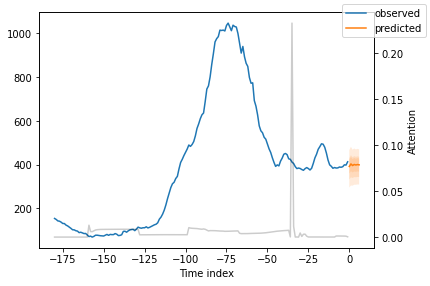

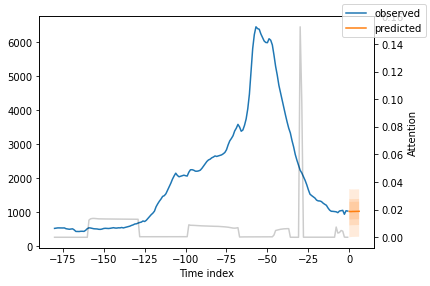

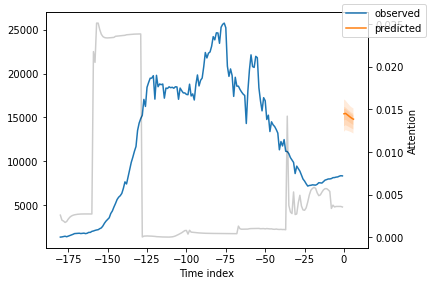

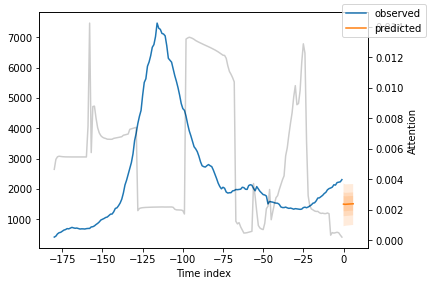

In [48]:
# plotting 7-day-avgss of new cases, attention, prediction, 
# and quantiles for(South) Korea, Japan, Germany, and Austria
for country in ("KOR", "JPN", "DEU", "AUT"):
    trained_model.plot_prediction(new_x, new_predictions, idx=new_index[country], show_future_observed=False);

The grey lines show the attention the model pays to certain points in time for making its predictions. As the graphs show, these periods will have consideraable weight in the resulting seven-day forecasts and drive the model to - in some cases - not foresee more recent jumps, especially if they were not included in the model training.
Also note that the time here is given as a time index in days from the last date in the new dataset.

## 6. Interpreting Attention & Variable Importance

One big advantage of TFTs is that they provide us with attentiuon values and variable importances, allowing us to make some inference.

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x522 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x630 with 1 Axes>}

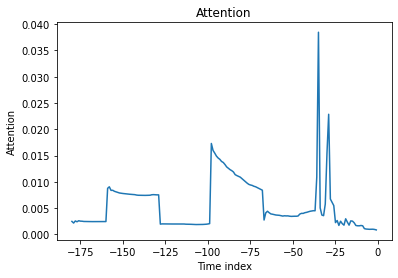

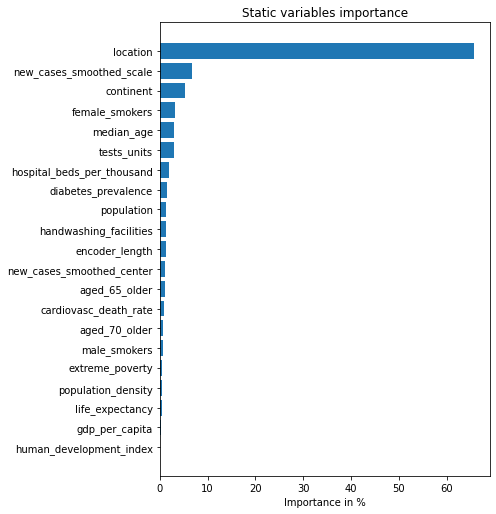

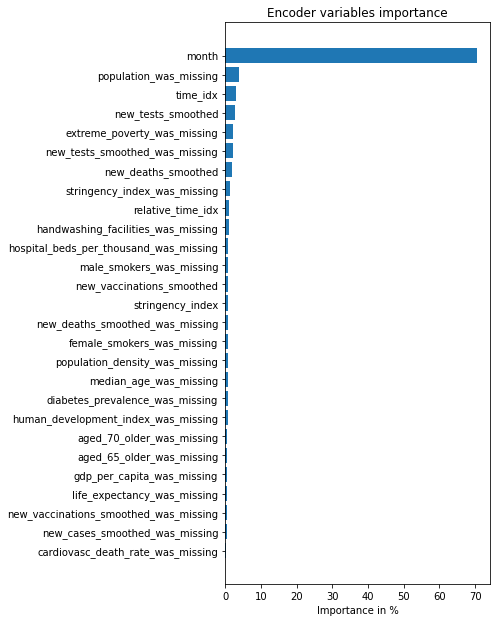

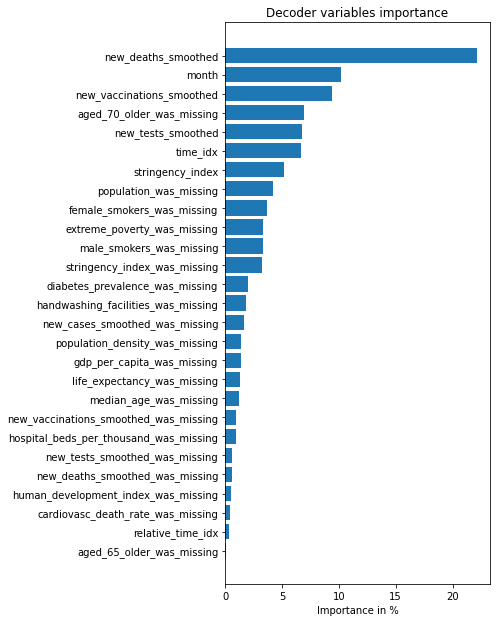

In [50]:
raw_predictions, new_x = trained_model.predict(pred_ts, mode="raw", return_x=True)
interpretation = trained_model.interpret_output(raw_predictions, reduction="sum")
trained_model.plot_interpretation(interpretation)

The attention the model pays to each period tells us, which points in time are considered the most important in making new forecasts. As we can see, the model considers values from six to four weeks before the most recent date as the most important ones. Given that we have a little more than two weeks between the most recent points in the training and the prediction data, we would conclude that values from four to two weeks prior to model training cxontribute the most to our estimates. This is consistent with ktthe time it might take until someone having contracted COVID-19 to show symptoms and be diagnosed, i.e. show up in the data.
This also shows how important it is to frequently re-train a TFT in order to keep predictions consistent with most recent developments.

For the variable importance statistics, it is not surprising that location and the value range into which previous case numbers fall would be considered the most important factors for preditions by the model. In fact, allowing for spatial interaction in the model might even yield more precise forecasts.

In the second graph, we also see that the mointh in which a measurement is of considerable importance for prediction, providing evidence for the seasonal pattern that we saw with COVID-19 in the past year and that we would also expect for other corona viruses, such as the common flu.

In the last graph, we can also see the role vaccination numbers play in the dynamics drving the data.

Lastly, we can also see that the model attributes quite some importance to our dummies for flagging mmissing values, suggesting that the fact whether numbers are reported or not already allows to draw some conclusions on actually realized values.

## 7. Where to Go From Here - Future Directions for Improvement 

As mentioned above, this model is far from done. The quite time-intensive training process put some pragmatic restrictions on this project, which was meant to primarily showcase how TFTs could be used in predicting the dynamics of pandemic events. Nonetheless, the model results, given its rather simplistic setup and ease of configuration show great promise.

Improving this model and putting in place sustainable pipelines for frequent re-training, as well as using more elaborate imputation strategies might be enough to make this model useful enough to inform political decision-makers and the general public of the situation and to hjelp implement forward-looking policies rather than having to rely on data that is already "outdated" by the time it is analyzed due to the long time COVID-19 cases are unreported.

A few suggestions for improvements might be:

- Allowing for spatial interaction by incorporating geographical data.
- Making counterfactual forecasts by simulating different scenarios when forward-filling values for covariates before making predictions.
- Using more sophisticated approaches to impute missing values.

I am convinced that applying machine learning techniques to time series forecasting opens up a wide array of possibilities that could help in decision making in times of crisis. 